# Homework 5: Convolutional neural network (30 points)


In this part, you need to implement and train a convolutional neural network on the CIFAR-10 dataset with PyTorch.
### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.
## How can I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.

Install PyTorch and Skorch.

In [1]:
!pip install -q torch skorch torchvision torchtext

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import skorch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/zjk/anaconda3/envs/cs182/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Tensor Operations (5 points)

Tensor operations are important in deep learning models. In this part, you are required to get famaliar to some common tensor operations in PyTorch.

### 1) Tensor squeezing, unsqueezing and viewing

Tensor squeezing, unsqueezing and viewing are important methods to change the dimension of a Tensor, and the corresponding functions are [torch.squeeze](https://pytorch.org/docs/stable/torch.html#torch.squeeze), [torch.unsqueeze](https://pytorch.org/docs/stable/torch.html#torch.unsqueeze) and [torch.Tensor.view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view). Please read the documents of the functions, and finish the following practice.

In [3]:
# x is a tensor with size being (3, 2)
x = torch.Tensor([[1, 2], 
                  [3, 4], 
                  [5, 6]])
x.shape

# Add two new dimensions to x by using the function torch.unsqueeze, so that the size of x becomes (3, 1, 2, 1).
x = torch.unsqueeze(x, 1)
x = torch.unsqueeze(x, 3)
print(x.shape)

# Remove the two dimensions justed added by using the function torch.squeeze, and change the size of x back to (3, 2).
x = torch.squeeze(x, 3)
x = torch.squeeze(x, 1)
# x = torch.squeeze(x, (0, 2)) # in torch 2.0 this will work 
print(x.shape)

# x is now a two-dimensional tensor, or in other words a matrix. Now use the function torch.Tensor.view and change x to a one-dimensional vector with size being (6).
x = x.view(6)
print(x.shape)

torch.Size([3, 1, 2, 1])
torch.Size([3, 2])
torch.Size([6])


### 2) Tensor concatenation and stack

Tensor concatenation and stack are operations to combine small tensors into big tensors. The corresponding functions are [torch.cat](https://pytorch.org/docs/stable/torch.html#torch.cat) and [torch.stack](https://pytorch.org/docs/stable/torch.html#torch.stack). Please read the documents of the functions, and finish the following practice.

In [4]:
# x is a tensor with size being (3, 2)
x = torch.Tensor([[1, 2], [3, 4], [5, 6]])

# y is a tensor with size being (3, 2)
y = torch.Tensor([[-1, -2], [-3, -4], [-5, -6]])

# Our goal is to generate a tensor z with size as (2, 3, 2), and z[0,:,:] = x, z[1,:,:] = y.

# Use torch.stack to generate such a z
z = torch.stack((x, y))
# print(z)
print(z[0,:,:])

# Use torch.cat and torch.unsqueeze to generate such a z
# print('torch.unsqueeze(x, 0) = ', torch.unsqueeze(x, 0))
z = torch.cat((torch.unsqueeze(x, 0), torch.unsqueeze(y, 0)))
# print(z)
print(z[1,:,:])

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
tensor([[-1., -2.],
        [-3., -4.],
        [-5., -6.]])


### 3) Tensor expansion

Tensor expansion is to expand a tensor into a larger tensor along singleton dimensions. The corresponding functions are [torch.Tensor.expand](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.expand) and [torch.Tensor.expand_as](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.expand_as). Please read the documents of the functions, and finish the following practice. 

In [5]:
# x is a tensor with size being (3)
x = torch.Tensor([1, 2, 3])

# Our goal is to generate a tensor z with size (2, 3), so that z[0,:,:] = x, z[1,:,:] = x.

# [TO DO]
# Change the size of x into (1, 3) by using torch.unsqueeze.
x = torch.unsqueeze(x, 0)
print(x.shape)

# [TO DO]
# Then expand the new tensor to the target tensor by using torch.Tensor.expand.
z = x.expand(2, -1)
# print(z)
print(z.shape)

torch.Size([1, 3])
torch.Size([2, 3])


### 4) Tensor reduction in a given dimension

In deep learning, we often need to compute the mean/sum/max/min value in a given dimension of a tensor. Please read the document of [torch.mean](https://pytorch.org/docs/stable/torch.html#torch.mean), [torch.sum](https://pytorch.org/docs/stable/torch.html#torch.sum), [torch.max](https://pytorch.org/docs/stable/torch.html#torch.max), [torch.min](https://pytorch.org/docs/stable/torch.html#torch.min), [torch.topk](https://pytorch.org/docs/stable/torch.html#torch.topk), and finish the following practice.

In [6]:
# x is a random tensor with size being (10, 50)
x = torch.randn(10, 50)

# Compute the mean value for each row of x.
# You need to generate a tensor x_mean of size (10), and x_mean[k, :] is the mean value of the k-th row of x.

# dim = 1: eliminate the second(1)'s dimension

x_mean = torch.mean(x, dim=1)
# print(x_mean)
print(x_mean[3, ])

# Compute the sum value for each row of x.
# You need to generate a tensor x_sum of size (10).
x_sum = torch.sum(x, dim=1)
print(x_sum.shape)

# Compute the max value for each row of x.
# You need to generate a tensor x_max of size (10).
(x_max, indices) = torch.max(x, dim=1)
# print(x_max, indices)
print(x_max.shape)

# Compute the min value for each row of x.
# You need to generate a tensor x_min of size (10).
(x_min, indices) = torch.min(x, dim=1)
print(x_min.shape)

# Compute the top-5 values for each row of x.
# (wrong) You need to generate a tensor x_mean of size (10, 5), and x_top[k, :] is the top-5 values of each row in x.
# (right) You need to generate a tensor, top-5 values of each row
(x_xtop, indices) = torch.topk(x, k=5, dim=1)
print((x_xtop.shape))

tensor(0.1017)
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10, 5])


## Convolutional Neural Networks



Implement a convolutional neural network for image classification on CIFAR-10 dataset.

CIFAR-10 is an image dataset of 10 categories. Each image has a size of 32x32 pixels. The following code will download the dataset, and split it into `train` and `test`. For this question, we use the default validation split generated by Skorch.

In [7]:
train = torchvision.datasets.CIFAR10("./data", train=True, download=True)
test = torchvision.datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


The following code visualizes some samples in the dataset. You may use it to debug your model if necessary.

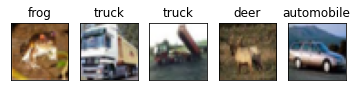

In [8]:
def plot(data, labels=None, num_sample=5):
  n = min(len(data), num_sample)
  for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(data[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    if labels is not None:
      plt.title(labels[i])

train.labels = [train.classes[target] for target in train.targets]
plot(train.data, train.labels)

### 1) Basic CNN implementation


Consider a basic CNN model

- It has 3 convolutional layers, followed by a linear layer.
- Each convolutional layer has a kernel size of 3, a padding of 1.
- ReLU activation is applied on every hidden layer.

Please implement this model in the following section. The hyperparameters is then be tuned and you need to fill the results in the table.

#### a) Implement convolutional layers (10 Points)

Implement the initialization function and the forward function of the CNN.

In [9]:
class CNN(nn.Module):
  def __init__(self, channels):
    super(CNN, self).__init__()
    # implement parameter definitions here
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # print('channels = ', channels)
    self.channels = channels
    
    self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()

    self.conv2 = nn.Conv2d(channels, channels // 2, kernel_size=3, padding=1)
    self.act2 = nn.ReLU()

    self.conv3 = nn.Conv2d(channels // 2, channels // 4, kernel_size=3, padding=1)
    self.act3 = nn.ReLU()

    # regard the image has the same size 32 * 32
    self.f1 = nn.Linear(channels // 4 * 32 * 32, 10)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
  def forward(self, images):
    # implement the forward function here
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    images = self.conv1(images)
    images = self.act1(images)

    images = self.conv2(images)
    images = self.act2(images)

    images = self.conv3(images)
    images = self.act3(images)


    # flatten the image
    images = images.view(images.shape[0], -1)
    images = self.f1(images)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return images

#### b) Tune hyperparameters

Train the CNN model on CIFAR-10 dataset. We can tune the number of channels, optimizer, learning rate and the number of epochs for best validation accuracy.

In [10]:
# implement hyperparameters, you can select and modify the hyperparameters by yourself here.

optimizer = [torch.optim.SGD, torch.optim.Adam]
learning_rate = [1e-3, 1e-2]
channel = [128, 256, 512]


train_data_normalized = torch.Tensor(train.data/255)
train_data_normalized = train_data_normalized.permute(0,3,1,2)

for l in learning_rate:
  for o in optimizer: 
    for c in channel:
      print(f'The channel was {c}, the learning rate was {l} and the optimizer was {str(o)}')

      cnn = CNN(channels = c)
      
      model = skorch.NeuralNetClassifier(cnn, criterion=torch.nn.CrossEntropyLoss,
                                   device="cuda",
                                   optimizer=o,
                                  #  optimizer__momentum=0.90,
                                   lr=l,
                                   max_epochs=50,
                                   batch_size=32,
                                   callbacks=[skorch.callbacks.EarlyStopping(lower_is_better=True)])
      # implement input normalization & type cast here 
      model.fit(train_data_normalized, np.asarray(train.targets))

The channel was 128, the learning rate was 0.001 and the optimizer was <class 'torch.optim.sgd.SGD'>
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2359       0.2701        2.0484  5.1466
      2        1.9353       0.3393        1.8644  4.1893
      3        1.8284       0.3689        1.7862  4.1966
      4        1.7653       0.3923        1.7310  4.1869
      5        1.7136       0.4081        1.6794  4.1917
      6        1.6657       0.4277        1.6370  4.1898
      7        1.6270       0.4401        1.6025  4.2256
      8        1.5923       0.4497        1.5691  4.2091
      9        1.5574       0.4645        1.5345  4.2796
     10        1.5219       0.4730        1.5004  4.2396
     11        1.4877       0.4803        1.4696  4.2615
     12        1.4564       0.4864        1.4430  4.2452
     13        1.4285       0.4949        1.4202  4.1881
     14        1.4032       0.5027        1.

Write down **validation accuracy** of your model under different hyperparameter settings. Note the validation set is automatically split by Skorch during `model.fit()`.


| #channel for each layer \ optimizer |  SGD  |  Adam |
|-------------------------------------|-------|-------|
|                                     |       |       |
|                                     |       |       |
|                                     |       |       |


### 2) Full CNN implementation (10 points)

Based on the CNN in the previous question, implement a full CNN model with max pooling layer.

- Add a max pooling layer after each convolutional layer.
- Each max pooling layer has a kernel size of 2 and a stride of 2.

Please implement this model in the following section. The hyperparameters is then be tuned and fill the results in the table. You are also required to complete the questions.

#### a) Implement max pooling layers

Similar to the CNN implementation in previous question, implement max pooling layers.

In [ ]:
class CNN_MaxPool(nn.Module):
  def __init__(self, channels):
    super(CNN_MaxPool, self).__init__()
    # implement parameter definitions here
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    self.channels = channels

    self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(channels, channels // 2, kernel_size=3, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(channels // 2, channels // 4, kernel_size=3, padding=1)
    self.act3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    # regard the image has the same size 32 * 32
    # after 3 max pooling, the size is 32 / 2 / 2 / 2 = 4
    self.f1 = nn.Linear(channels // 4 * 4 * 4, 10)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
  def forward(self, images):
    # implement the forward function here
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    images = self.conv1(images)
    images = self.act1(images)
    images = self.pool1(images)

    images = self.conv2(images)
    images = self.act2(images)
    images = self.pool2(images)

    images = self.conv3(images)
    images = self.act3(images)
    images = self.pool3(images)

    # flatten the image
    images = images.view(images.shape[0], -1)

    images = self.f1(images)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return images

#### b) Tune hyperparameters

Based on the better optimizer found in the previous problem, we can tune the number of channels and learning rate for best validation accuracy.

In [ ]:
# implement hyperparameters, you can select and modify the hyperparameters by yourself here.
learning_rate = [1e-4, 1e-3, 1e-2]
channel = [128, 256, 512]
# Select the better optimizer by the result shown in the previous problem, you can select and modify it by yourself here.
better_optimizer = torch.optim.Adam  

train_data_normalized = torch.Tensor(train.data/255)
train_data_normalized = train_data_normalized.permute(0,3,1,2)

for l in learning_rate:
    for c in channel:
      print(f'The channel was {c}, the learning rate was {l}')

      cnn = CNN_MaxPool(channels = c)
      
      model = skorch.NeuralNetClassifier(cnn, criterion=torch.nn.CrossEntropyLoss,
                                   device="cuda",
                                   optimizer=better_optimizer,
                                   lr=l,
                                   max_epochs=50,
                                   batch_size=32,
                                   callbacks=[skorch.callbacks.EarlyStopping(lower_is_better=True)])
      # implement input normalization & type cast here 
      model.fit(train_data_normalized, np.asarray(train.targets))

Write down the **validation accuracy** of the model under different hyperparameter settings.

| #channel for each layer | validation accuracy |
|-------------------------|---------------------|
|                         |                     |
|                         |                     |
|                         |                     |

For the best model you have, test it on the test set.

In [ ]:
# implement the same input normalization & type cast here
test_data_normalized = torch.Tensor(test.data/255) 
test_data_normalized = test_data_normalized.permute(0,3,1,2)
test.predictions = model.predict(test_data_normalized)
sklearn.metrics.accuracy_score(test.targets, test.predictions)

How much **test accuracy** do you get? What can you conclude for the design of CNN structure and tuning of hyperparameters? (5 points)

**Your Answer:** 